In [2]:
import numpy as np
import pandas as pd

from scipy.stats import skew, boxcox

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [4]:
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input//test.csv')
sub = pd.read_csv("input/sample_submission.csv")

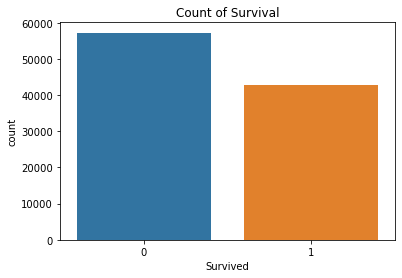

In [5]:
plt.subplots(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title("Count of Survival")
plt.show()

In [7]:
print(f"{len(train[train['Survived']==1])/len(train)}% survived")

0.42774% survived


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


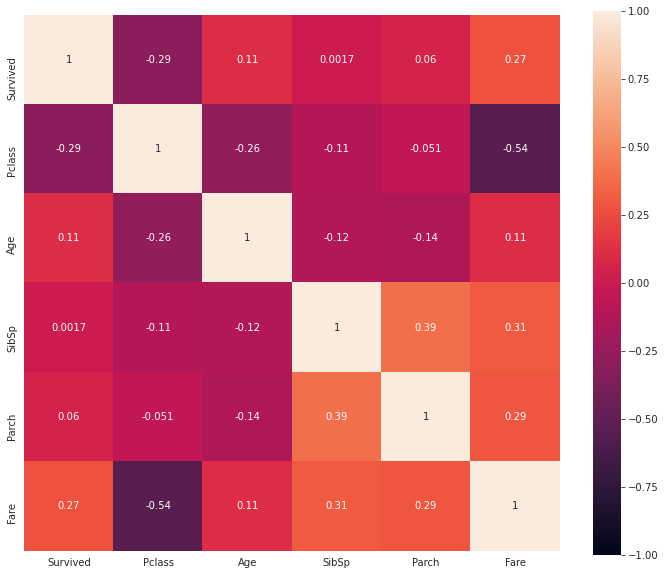

In [9]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(train[['Survived','Pclass','Age','SibSp','Parch','Fare']].corr(method='spearman'), annot=True, square=True, vmin=-1, vmax=1)#

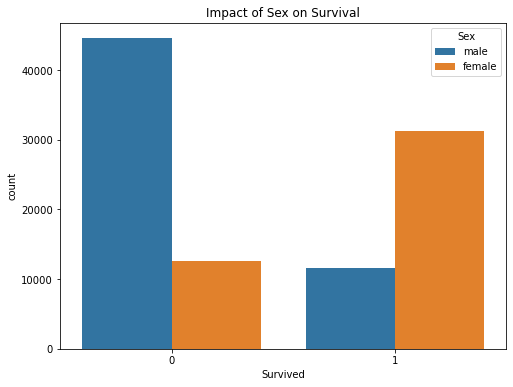

In [10]:
plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Sex')
plt.title("Impact of Sex on Survival")
plt.show()

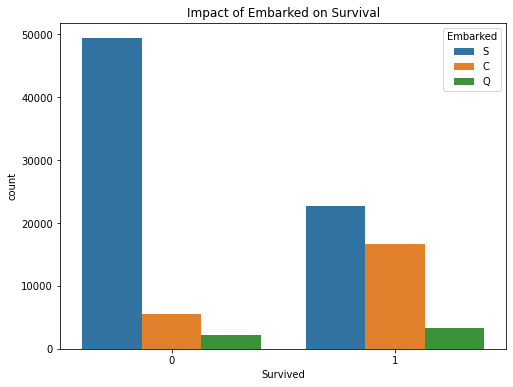

In [11]:
plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Embarked')
plt.title("Impact of Embarked on Survival")
plt.show()

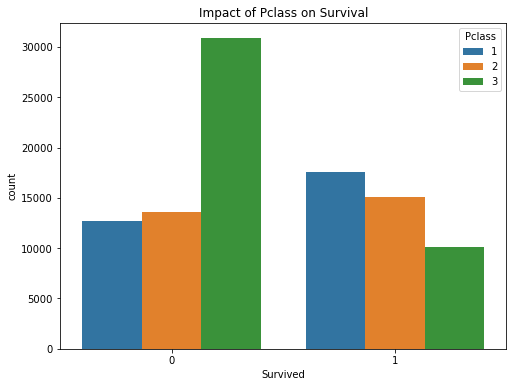

In [12]:
plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Pclass')
plt.title("Impact of Pclass on Survival")
plt.show()

In [13]:
y = train.Survived.values

train.drop(['Survived','PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)
print(f"train size is : {train.shape}")
print(f"test size is : {test.shape}")

train size is : (100000, 10)
test size is : (100000, 10)


In [14]:
df_na = (train.isnull().sum() / len(train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : df_na})
missing_data.head(5)

,Missing Ratio
Cabin,67.866
Ticket,4.623
Age,3.292
Embarked,0.250
Fare,0.134


In [15]:
test.Cabin    = test.Cabin.fillna('0')
train.Cabin   = train.Cabin.fillna('0')

train.Ticket  = train.Ticket.fillna(train.Ticket.mode()[0])
test.Ticket   = test.Ticket.fillna(test.Ticket.mode()[0])

train.Age      = train.Age.fillna(train.Age.median())
test.Age       = test.Age.fillna(train.Age.median())

train.Embarked = train.Embarked.fillna(train.Embarked.mode()[0])
test.Embarked  = test.Embarked.fillna(train.Embarked.mode()[0])

train.Fare     = train.Fare.fillna(train.Fare.mean())
test.Fare      = test.Fare.fillna(test.Fare.mean())

In [16]:
train.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [17]:
train['Cabin_'] = train['Cabin'].map(lambda x: x[0].strip())
test['Cabin_'] = test['Cabin'].map(lambda x: x[0].strip())

train['HasCabin'] = train.Cabin.apply(lambda x: 0 if x=='0' else 1).astype('category')
test['HasCabin'] = test.Cabin.apply(lambda x: 0 if x=='0' else 1).astype('category')

train['Ticket_'] = train['Ticket'].str.replace('[^\w\s]','').replace(' ','').fillna('NA').replace('(\d)', '', regex=True)
test['Ticket_'] = test['Ticket'].str.replace('[^\w\s]','').replace(' ','').fillna('NA').replace('(\d)', '', regex=True)

train['FirstName'] = train['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()
test['FirstName'] = test['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()

train['IsWoman'] = (train['Sex']=='female').astype('category')
test['IsWoman'] = (test['Sex']=='female').astype('category')

train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

train.drop(['Name','Cabin','Ticket'], axis=1, inplace=True)
test.drop(['Name','Cabin','Ticket'], axis=1, inplace=True)

In [18]:
numeric_feats = train.dtypes[(train.dtypes != "object") & (train.dtypes != 'category')].index.tolist()
object_feats  = train.dtypes[(train.dtypes == "object") | (train.dtypes == 'category')].index.tolist()

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness)

for i in skewness.index:
    train[i]=np.log1p(train[i])
    test[i]=np.log1p(test[i])

                Skew
Fare        3.923142
SibSp       3.759607
Parch       3.537693
FamilySize  2.375445
Age        -0.159802
Pclass     -0.203086


In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), object_feats),
        ('num', RobustScaler() , numeric_feats)
    ])

In [20]:
clf = Pipeline(steps=[
                    ('pre', preprocessor),
                    ('a', LogisticRegression(random_state=42)),
                    ])

In [22]:
param_grid = {
    'a__C': list(np.linspace(0.05, 0.07, 20)),
    'a__max_iter': list(range(40, 120, 10)),
    'a__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [24]:
a = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10).fit(train, y)
a.best_estimator_

KeyboardInterrupt: 

In [ ]:
sub['Survived'] = predictions
sub.to_csv('input/submission.csv',index=False)